In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from time import time

from data import FESDDataset
from data import Frame, AugmentationParams
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
sns.set()

from PIL import Image

import cv2

from model import FESD, train, val, test
import copy

import scipy

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

import datetime

from utils import AvgMeter, clip_gradient, get_scheduler
from utils.mode import Mode
from utils import err2gt, gt2err

from copy import deepcopy

from tqdm.notebook import tqdm

num_gpus = torch.cuda.device_count()
is_cuda = torch.cuda.is_available()
print(f"Num cuda GPUs: {num_gpus}")
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

Num cuda GPUs: 0


In [3]:
RECORDING_DIR = Path('D:/Recordings/')
CHECKPOINT_DIR = Path('checkpoints')

## Data Loading

Firstly we need to import all the recordings into the notebook.


In [4]:
with open(file="Exercises.json", mode='r') as file:
  exercises_json = json.load(file)['Exercises']

with open(file="JointErrors.json", mode='r') as file:
  joint_error_json = json.load(file)

with open(file="SkeletonErrors.json", mode='r') as file:
  skeleton_error_json = json.load(file)

len(exercises_json)

13

In [5]:
batchsize = 10
im_size = 450
use_v2 = False

test_exercises = ['E-0.01', 'E-1.01', 'E-2.01', 'E-3.01']

dataset_train = FESDDataset(RECORDING_DIR, im_size, test_exercises, randomize_augmentation_params=True)
dataset_train.randomize_augmentation_params = True

dataset_test = FESDDataset(RECORDING_DIR, im_size, test_exercises, test=True)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize)
test_loader = torch.utils.data.DataLoader(dataset_test)

Recordings Found: 17
Total Frames: 510
Recordings Found: 9
Total Frames: 270


In [6]:
joint_names_all = ["-", "Head", "Neck", "Torso", "Waist", "Left collar", "Left shoulder", "Left elbow", "Left wrist", "Left hand", "-", "Right collar", "Right shoulder", "Right elbow", "Right wrist", "Right hand", "-", "Left hip", "Left knee", "Left ankle", "-", "Right hip", "Right knee", "Right ankle", "-"]
joint_names = [i for i in joint_names_all if i != '-']

body_halves = np.array(["Upper Half", "Lower Half"])
limbs = np.array(["Head", "Torso", "Left arm", "Right arm", "Left leg", "Right leg"])

upper_body_i = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
lower_body_i = [3, 14, 15, 16, 17, 18, 19]

torso_i     = [2, 3, 4, 9]
head_i      = [0, 1]
left_arm_i  = [5, 6, 7, 8]
right_arm_i = [10, 11, 12, 13]
left_leg_i  = [14, 15, 16]
right_leg_i = [17, 18, 19]

joint_errors = []
for je in joint_error_json:
  joint_errors.append(je["Name"])

## Data Augmentations

Here we show the different data augmentations

None

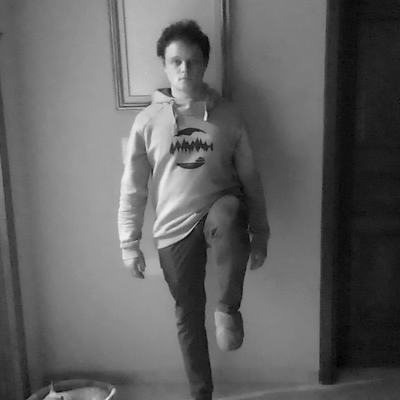

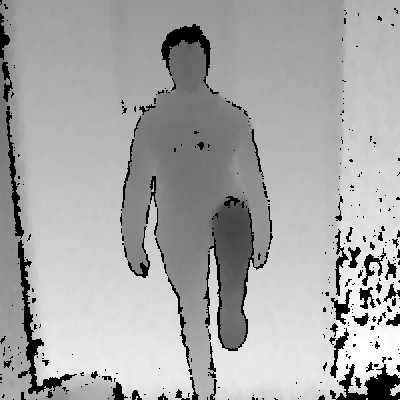

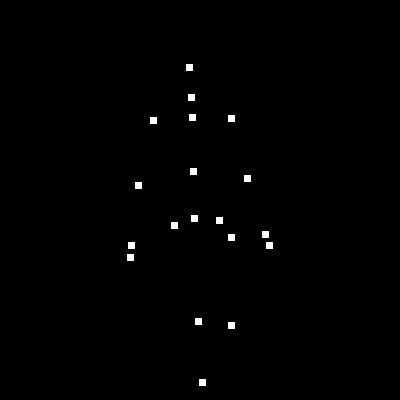

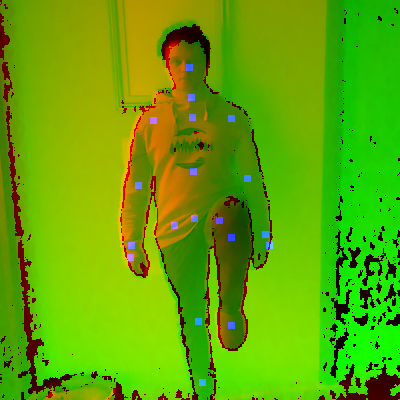

In [8]:
i = 103
mode = Mode.JOINTS
dataset_train.mode = mode
dataset_train.use_v2 = True
dataset_train.randomize_augmentation_params = False
dataset_train.reset_augmentation_params()
dataset_train.to_tensor = lambda x: x
show_im = True

merged_image, gt, session = dataset_train[i]
if dataset_train.augmentation_params.gaussian != True and dataset_train.augmentation_params.crop_random != True and dataset_train.randomize_augmentation_params != True:
  display(merged_image.split()[0].save("figures/data/greyscale.png"))
  merged_image.split()[1].save("figures/data/depth.png")
  merged_image.split()[2].save("figures/data/joint.png")
  merged_image.save("figures/data/merged.png")
if show_im:
  display(merged_image.split()[0], merged_image.split()[1], merged_image.split()[2])
  display(merged_image)

dataset_train.use_v2 = use_v2

150
(150, 150)


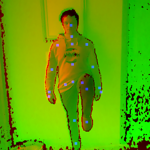

In [19]:
from PIL import ImageOps
im_size = 150
print(im_size)
new_im = ImageOps.scale(merged_image, im_size/400)
print(new_im.size)
new_im

In [8]:
i = 103
mode = Mode.JOINTS
dataset_train.mode = mode
dataset_train.randomize_augmentation_params = False
dataset_train.reset_augmentation_params()
dataset_train.use_v2 = False
show_im = True

rgb, depth, pose_2d, gt, session = dataset_train[i]
rgb.save("figures/augmentation/rgb_original.png")
depth.save("figures/augmentation/depth_original.png")

dataset_train.augmentation_params.flip = True
rgb, depth, pose_2d, gt, session = dataset_train[i]
rgb.save("figures/augmentation/rgb_flip.png")
depth.save("figures/augmentation/depth_flip.png")

dataset_train.augmentation_params.flip = False
dataset_train.augmentation_params.gaussian = True
rgb, depth, pose_2d, gt, session = dataset_train[i]
rgb.save("figures/augmentation/rgb_blur.png")
depth.save("figures/augmentation/depth_blur.png")

dataset_train.augmentation_params.gaussian = False
dataset_train.augmentation_params.crop_random = True
rgb, depth, pose_2d, gt, session = dataset_train[i]
rgb.save("figures/augmentation/rgb_crop.png")
depth.save("figures/augmentation/depth_crop.png")

dataset_train.augmentation_params.crop_pad = 20
rgb, depth, pose_2d, gt, session = dataset_train[i]
rgb.save("figures/augmentation/rgb_crop_pad.png")
depth.save("figures/augmentation/depth_crop_pad.png")

dataset_train.use_v2 = use_v2

## Data Analysis

Now that the data is loaded we can analyse it

In [9]:
cols = ['Type', 'Session', 'Difficulty', 'Exercise', 'Frame', 'Joint', 'Error', 'mode']
df_data = pd.DataFrame(columns=cols)

for i in tqdm(range(len(dataset_train))):
  for m in [Mode.FULL_BODY, Mode.HALF_BODY, Mode.LIMBS, Mode.JOINTS]:
    dataset_train.mode = m
    rgb, depth, pose_2d, gt, session = dataset_train[i]

    gt = gt2err(gt, m)[0]
    session, frame_i = dataset_train.get_index(i)
    frame = dataset_train.frame
    session_name = frame.session["Name"]
    exercise = frame.session['Session Parameters']['Exercise']
    difficulty = int(exercise[2])

    for j, err in enumerate(gt):
      row = ["Train", session_name, difficulty, exercise, frame_i, j, int(err), m]
      df_data.loc[len(df_data)] = row

for i in tqdm(range(len(dataset_test))):
  for m in [Mode.FULL_BODY, Mode.HALF_BODY, Mode.LIMBS, Mode.JOINTS]:
    dataset_test.mode = m
    _, _, _, gt, _ = dataset_test[i]
    gt = gt2err(gt, m)[0]
    session, frame_i = dataset_test.get_index(i)
    frame = dataset_test.frame
    session_name = frame.session["Name"]
    exercise = frame.session['Session Parameters']['Exercise']
    difficulty = int(exercise[2])

    for j, err in enumerate(gt):
      row = ["Test", session_name, difficulty, exercise, frame_i, j, int(err), m]
      df_data.loc[len(df_data)] = row

dataset_train.mode = mode
dataset_test.mode = mode
df_data

  0%|          | 0/510 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

,Type,Session,Difficulty,Exercise,Frame,Joint,Error,mode
0,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,1,Mode.FULL_BODY
1,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,1,Mode.HALF_BODY
2,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,1,1,Mode.HALF_BODY
3,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,0,Mode.LIMBS
4,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,1,0,Mode.LIMBS
...,...,...,...,...,...,...,...,...
22615,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,15,0,Mode.JOINTS
22616,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,16,1,Mode.JOINTS
22617,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,17,0,Mode.JOINTS
22618,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,18,0,Mode.JOINTS


In [10]:
df_data_joints    = df_data[df_data['mode'] == Mode.JOINTS]
df_data_limbs     = df_data[df_data['mode'] == Mode.LIMBS]
df_data_half_body = df_data[df_data['mode'] == Mode.HALF_BODY]
df_data_full_body = df_data[df_data['mode'] == Mode.FULL_BODY]

### Error Distribution Per Joint

Here we investigate the distribution of errors based on Body regions

In [11]:
df_data_joints["pose_id"]      = df_data_joints["Session"] + "_" + df_data_joints["Frame"].astype(str)
df_data_joints["error_simple"] = df_data_joints["Error"].apply(lambda x: 1 if x > 0 else 0)
df_data_joints["joint_name"]   = df_data_joints["Joint"].apply(lambda x: joint_names[x])

In [12]:
class_dict_halves = Mode.HALF_BODY.get_class_dict()
df_data_joints["Upper Body"] = df_data_joints["Joint"].apply(lambda x: x in class_dict_halves["Upper Body"])
df_data_joints["Lower Body"] = df_data_joints["Joint"].apply(lambda x: x in class_dict_halves["Lower Body"])

class_dict_limbs = Mode.LIMBS.get_class_dict()
df_data_joints["Torso"]     = df_data_joints["Joint"].apply(lambda x: x in class_dict_limbs["Torso"])
df_data_joints["Head"]      = df_data_joints["Joint"].apply(lambda x: x in class_dict_limbs["Head"])
df_data_joints["Left Arm"]  = df_data_joints["Joint"].apply(lambda x: x in class_dict_limbs["Left Arm"])
df_data_joints["Right Arm"] = df_data_joints["Joint"].apply(lambda x: x in class_dict_limbs["Right Arm"])
df_data_joints["Left Leg"]  = df_data_joints["Joint"].apply(lambda x: x in class_dict_limbs["Left Leg"])
df_data_joints["Right Leg"] = df_data_joints["Joint"].apply(lambda x: x in class_dict_limbs["Right Leg"])

In [13]:
df_data_joints["body_half"] = df_data_joints["Joint"].apply(lambda x: Mode.HALF_BODY.get_class(x))
df_data_joints["body_part"] = df_data_joints["Joint"].apply(lambda x: Mode.LIMBS.get_class(x))

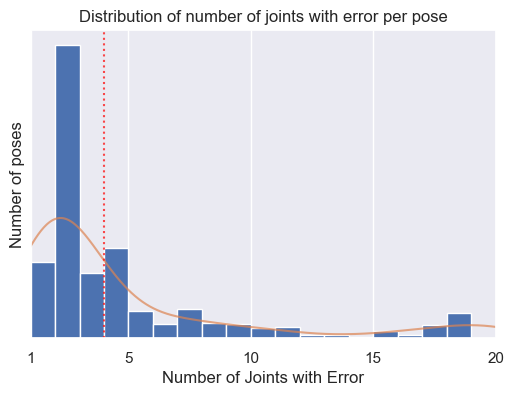

In [14]:
fig, ax = plt.subplots(figsize = (6, 4))
error_distr = df_data_joints.groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]
error_distr = error_distr[error_distr > 0]
error_distr.plot.hist(bins = range(1, 20), density=True)
error_distr.plot(kind = "kde", alpha = 0.7)
quant = error_distr.quantile(0.7)
ax.axvline(quant, color="red", alpha = .7, ymax = 1, linestyle = ":")
ax.set_title("Distribution of number of joints with error per pose")
ax.set_xlabel("Number of Joints with Error")
ax.set_ylabel("Number of poses")
ax.set_xlim(1, 20)
ax.set_xticks([1, 5, 10, 15, 20])
ax.set_yticks([])
plt.savefig("figures/distribution_of_joint_errors_per_pose.png")
plt.show()

C:\Users\leona\AppData\Local\Temp\ipykernel_6524\897643579.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  err_dist_upper = df_data_joints[df_data_joints["body_half"] == "Upper Body"][df_data_joints["error_simple"] == 1].groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]


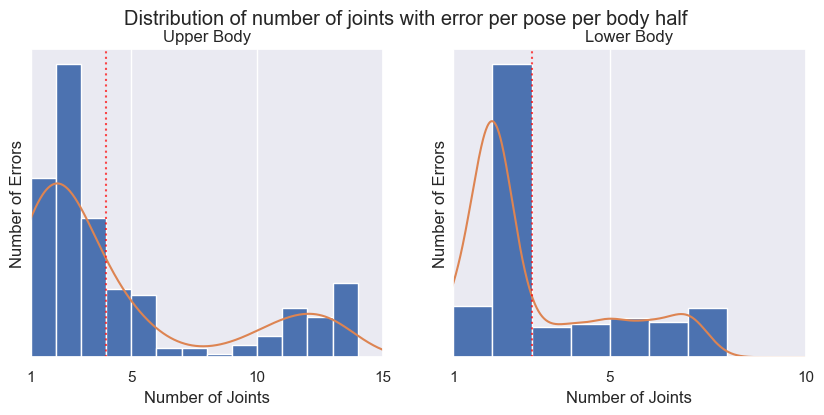

In [15]:
fig, axs = plt.subplots(figsize = (10,4), nrows=1, ncols=2)

err_dist_upper = df_data_joints[df_data_joints["body_half"] == "Upper Body"][df_data_joints["error_simple"] == 1].groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]
err_dist_lower = df_data_joints[df_data_joints["body_half"] == "Lower Body"].groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]

err_dist_upper = err_dist_upper[err_dist_upper > 0]
err_dist_lower = err_dist_lower[err_dist_lower > 0]

err_dist_upper.plot.hist(bins = range(1, 16), density=True, ax = axs[0])
err_dist_upper.plot(kind = "kde", ax = axs[0])

err_dist_lower.plot.hist(bins = range(1, 11), density=True, ax = axs[1])
err_dist_lower.plot(kind = "kde", ax = axs[1])

fig.suptitle("Distribution of number of joints with error per pose per body half")
axs[0].set_title("Upper Body")
axs[1].set_title("Lower Body")

axs[0].set_xlim(1, 15)
axs[0].set_xticks([1, 5, 10, 15])
axs[1].set_xlim(1, 10)
axs[1].set_xticks([1, 5, 10])

quant = err_dist_upper.quantile(0.7)
axs[0].axvline(quant, color="red", alpha = .7, ymax = 1, linestyle = ":")

quant = err_dist_lower.quantile(0.7)
axs[1].axvline(quant, color="red", alpha = .7, ymax = 1, linestyle = ":")


for ax in axs:
  ax.set_ylabel("Number of Errors")
  ax.set_xlabel("Number of Joints")
  ax.set_yticks([])

plt.savefig("figures/distribution_of_joint_errors_per_pose_per_body_half.png")
plt.show()

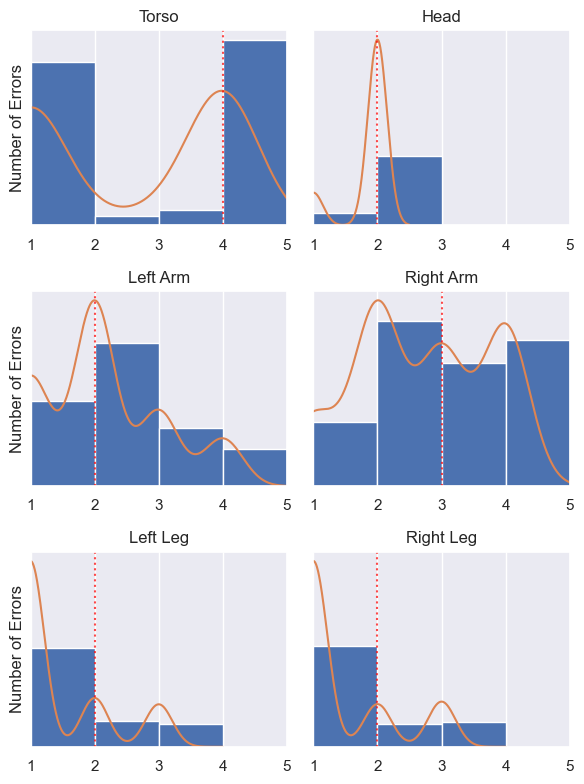

{'Torso': 4.0, 'Head': 2.0, 'Left Arm': 2.0, 'Right Arm': 3.0, 'Left Leg': 2.0, 'Right Leg': 2.0}


In [16]:
fig, axs = plt.subplots(figsize = (6,8), nrows=3, ncols=2)

def plot_error_distribution(df, body_part, thresh_dict, ax):
  err_dist = df[df["body_part"] == body_part].groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]
  err_dist = err_dist[err_dist > 0]

  err_dist.plot.hist(bins = range(1, 11), density=True, ax = ax)
  err_dist.plot(kind = "kde", ax = ax)

  ax.set_title(body_part)

  quant = err_dist.quantile(0.7)
  thresh_dict[body_part] = quant
  ax.axvline(quant, color="red", alpha = .7, ymax = 1, linestyle = ":")

  ax.set_xlim(1, 5)
  ax.set_xticks([1, 2, 3, 4, 5])
  ax.set_yticks([])


thresh_dict = {}

plot_error_distribution(df_data_joints, "Torso",      thresh_dict, axs[0,0])
plot_error_distribution(df_data_joints, "Head",       thresh_dict, axs[0,1])
plot_error_distribution(df_data_joints, "Left Arm",   thresh_dict, axs[1,0])
plot_error_distribution(df_data_joints, "Right Arm",  thresh_dict, axs[1,1])
plot_error_distribution(df_data_joints, "Left Leg",   thresh_dict, axs[2,0])
plot_error_distribution(df_data_joints, "Right Leg",  thresh_dict, axs[2,1])

for ax in axs:
  ax[0].set_ylabel("Number of Errors")
  ax[1].set_ylabel("")
  
plt.tight_layout()
plt.savefig("figures/distribution_of_joint_errors_per_pose_per_body_part.png")
plt.show()

print(thresh_dict)

### Error Distribution

Here we investigate the distribution of errors over the dataset for different body regions

#### Joints

In [17]:
df_data_joints["Joint Name"] = df_data_joints["Joint"].apply(lambda x: joint_names[x])
df_data_joints["Simple Error"] = df_data_joints["Error"] != 0
df_data_joints["Difficulty Name"] = df_data_joints["Difficulty"].apply(lambda x: "Trivial" if x == 0 else "Easy" if x == 1 else "Medium" if x == 2 else "Hard")
df_data_joints

,Type,Session,Difficulty,Exercise,Frame,Joint,Error,mode,pose_id,error_simple,...,Head,Left Arm,Right Arm,Left Leg,Right Leg,body_half,body_part,Joint Name,Simple Error,Difficulty Name
9,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,0,Mode.JOINTS,Session 2023-02-28T22:58:23_0,0,...,True,False,False,False,False,Upper Body,Head,Head,False,Trivial
10,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,1,0,Mode.JOINTS,Session 2023-02-28T22:58:23_0,0,...,True,False,False,False,False,Upper Body,Head,Neck,False,Trivial
11,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,2,0,Mode.JOINTS,Session 2023-02-28T22:58:23_0,0,...,False,False,False,False,False,Upper Body,Torso,Torso,False,Trivial
12,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,3,0,Mode.JOINTS,Session 2023-02-28T22:58:23_0,0,...,False,False,False,False,False,Lower Body,Torso,Waist,False,Trivial
13,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,4,0,Mode.JOINTS,Session 2023-02-28T22:58:23_0,0,...,False,False,False,False,False,Upper Body,Torso,Left collar,False,Trivial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22615,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,15,0,Mode.JOINTS,Session 2023-03-01T14:55:16_29,0,...,False,False,False,True,False,Lower Body,Left Leg,Left knee,False,Hard
22616,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,16,1,Mode.JOINTS,Session 2023-03-01T14:55:16_29,1,...,False,False,False,True,False,Lower Body,Left Leg,Left ankle,True,Hard
22617,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,17,0,Mode.JOINTS,Session 2023-03-01T14:55:16_29,0,...,False,False,False,False,True,Lower Body,Right Leg,Right hip,False,Hard
22618,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,18,0,Mode.JOINTS,Session 2023-03-01T14:55:16_29,0,...,False,False,False,False,True,Lower Body,Right Leg,Right knee,False,Hard


[]

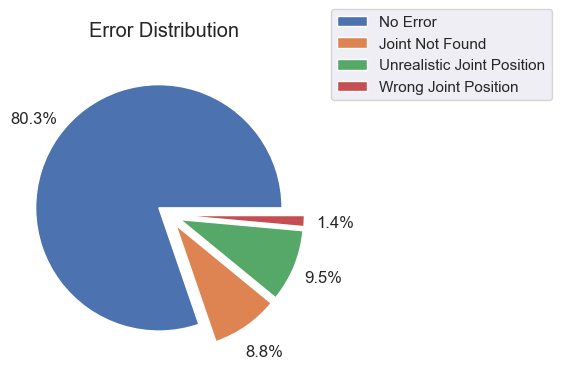

In [18]:
ax = df_data_joints[["Error", "Frame"]].groupby("Error").count().plot.pie(subplots=True, figsize=(4, 4), title="Error Distribution", labels=joint_errors, autopct='%1.1f%%', pctdistance=1.25, fontsize=12, explode=(.1,.1,.1,.1), labeldistance=None)

ax[0].set_ylabel("")
ax[0].legend(bbox_to_anchor=(1, 1.02), loc='center left')

plt.savefig("figures/dist_joints/Error_Distribution.png")
plt.plot()

<Axes: title={'center': 'Error Rate by Difficulty'}, xlabel='Difficulty', ylabel='Error Rate'>

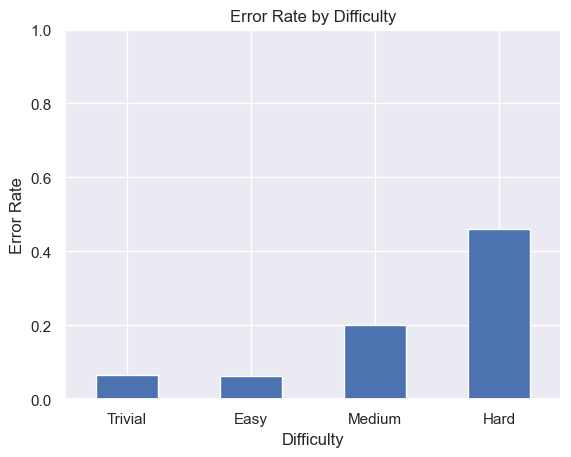

In [19]:
error_by_difficulty = df_data_joints[['Difficulty', "Difficulty Name", "Simple Error"]].groupby(["Difficulty Name"]).mean().sort_values(by="Difficulty")["Simple Error"]
ax = error_by_difficulty.plot.bar()
ax.set_ylabel("Error Rate")
ax.set_xlabel("Difficulty")
ax.set_title("Error Rate by Difficulty")
ax.set_ylim(0, 1)
labels = ['Trivial', 'Easy', 'Medium', 'Hard']
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(labels, rotation=0, ha='center')
plt.savefig("figures/dist_joints/Error_Rate_by_Difficulty.png")
ax

[]

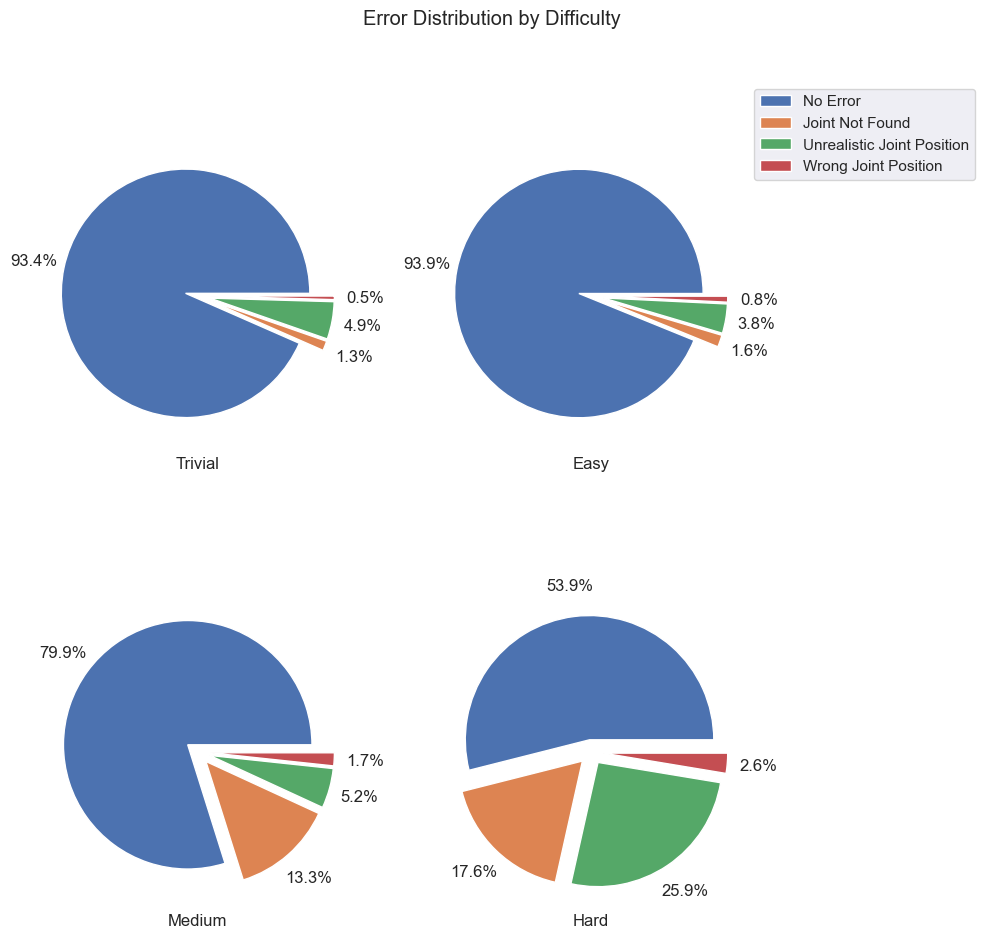

In [20]:
err_group = df_data_joints[['Difficulty', "Difficulty Name", "Error"]].groupby(["Difficulty Name", "Error"]).count()["Difficulty"].unstack().T
error_distribution_by_difficulty = (err_group / err_group.sum()).T
error_distribution_by_difficulty['sort_key'] = pd.CategoricalIndex(error_distribution_by_difficulty, [3, 0, 2, 1])
error_distribution_by_difficulty.sort_values('sort_key', inplace=True)
error_distribution_by_difficulty.drop('sort_key', axis=1, inplace=True)

axs = error_distribution_by_difficulty.T.plot.pie(subplots=True, figsize=(10, 10), layout=(2, 2), legend=False, title="Error Distribution by Difficulty", labels=joint_errors, autopct='%1.1f%%', pctdistance=1.25, fontsize=12, explode=(.1,.1,.1,.1), sharex=False, sharey=False, labeldistance=None)

axs[0, 0].set_xlabel("Trivial")
axs[0, 0].set_ylabel("")
axs[0, 1].set_xlabel("Easy")
axs[0, 1].set_ylabel("")
axs[0, 1].legend(bbox_to_anchor=(1, 1.02), loc='center left')
axs[1, 0].set_xlabel("Medium")
axs[1, 0].set_ylabel("")
axs[1, 1].set_xlabel("Hard")
axs[1, 1].set_ylabel("")

plt.tight_layout()
plt.savefig("figures/dist_joints/Error_Distribution_by_Difficulty.png")
plt.plot()

C:\Users\leona\AppData\Local\Temp\ipykernel_6524\890484243.py:18: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axs = edj.plot.pie(ax=ax1, subplots=True, figsize=(10, 10), layout=(4, 5), legend=False, title="Error Distribution by Joint", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.05,.05,.1))


[]

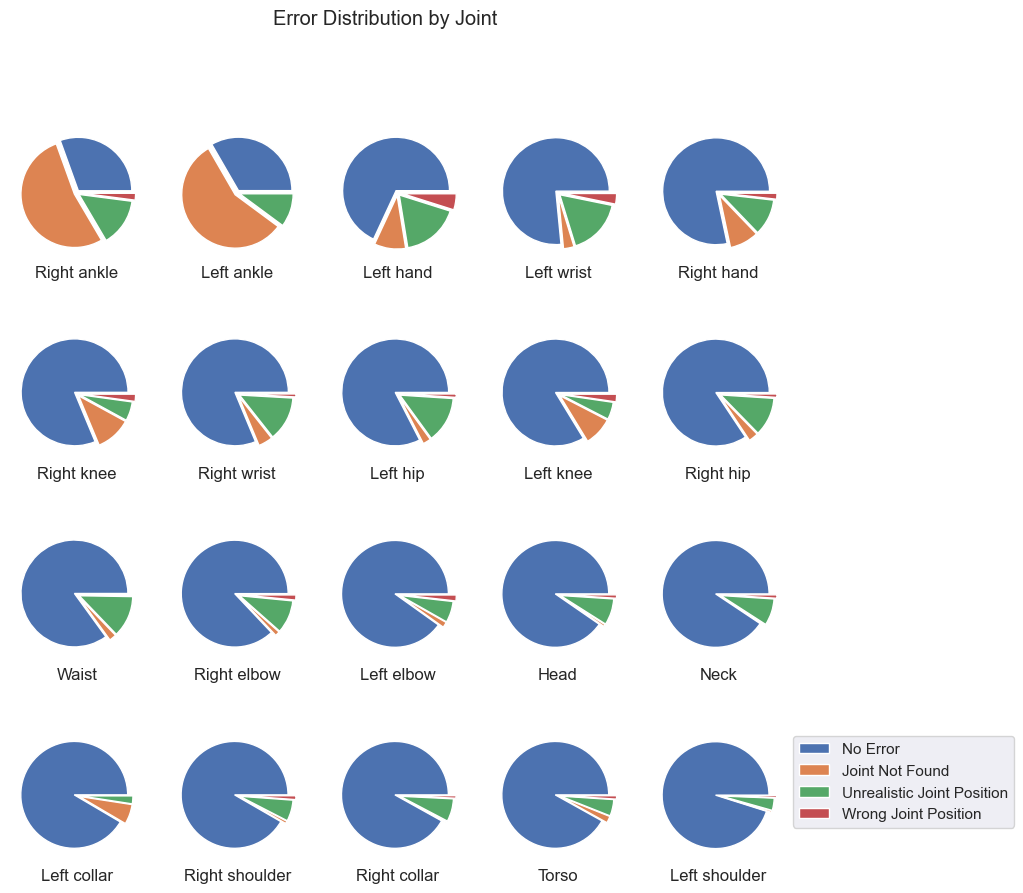

In [21]:
s = df_data_joints[["Joint", "Simple Error"]].groupby(["Joint"]).sum()
s["Sorted Names"] = joint_names
s = s.sort_values(by="Simple Error", ascending=False)

err_joints = df_data_joints[["Joint", "Joint Name", "Error"]]
error_distribution_by_joint = err_joints.groupby(["Joint", "Error"]).count().unstack().reindex(s.index).T

error_distribution_by_joint = (error_distribution_by_joint / error_distribution_by_joint.sum()).T.fillna(0)
error_distribution_by_joint.columns = error_distribution_by_joint.columns.droplevel()

error_distribution_by_joint.index = s["Sorted Names"].tolist()

edj = error_distribution_by_joint.T

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1)

axs = edj.plot.pie(ax=ax1, subplots=True, figsize=(10, 10), layout=(4, 5), legend=False, title="Error Distribution by Joint", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.05,.05,.1))

for ax in axs.flatten():
  ax.set_xlabel(ax.get_ylabel())
  ax.set_ylabel("")

plt.legend(joint_errors, loc='upper left', bbox_to_anchor=(1, 1))

ax1.set_title("Error Distribution by Joint")
plt.savefig("figures/dist_joints/Error_Distribution_by_Joint.png")
plt.plot()

#### Full Body

In [22]:
df_data_full_body["Joint Name"] = df_data_full_body["Joint"].apply(lambda x: joint_names[x])
df_data_full_body["Difficulty Name"] = df_data_full_body["Difficulty"].apply(lambda x: "Trivial" if x == 0 else "Easy" if x == 1 else "Medium" if x == 2 else "Hard")
df_data_full_body

,Type,Session,Difficulty,Exercise,Frame,Joint,Error,mode,Joint Name,Difficulty Name
0,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,1,Mode.FULL_BODY,Head,Trivial
29,Train,Session 2023-02-28T22:58:23,0,E-0.00,1,0,1,Mode.FULL_BODY,Head,Trivial
58,Train,Session 2023-02-28T22:58:23,0,E-0.00,2,0,1,Mode.FULL_BODY,Head,Trivial
87,Train,Session 2023-02-28T22:58:23,0,E-0.00,3,0,1,Mode.FULL_BODY,Head,Trivial
116,Train,Session 2023-02-28T22:58:23,0,E-0.00,4,0,0,Mode.FULL_BODY,Head,Trivial
...,...,...,...,...,...,...,...,...,...,...
22475,Test,Session 2023-03-01T14:55:16,3,E-3.01,25,0,1,Mode.FULL_BODY,Head,Hard
22504,Test,Session 2023-03-01T14:55:16,3,E-3.01,26,0,1,Mode.FULL_BODY,Head,Hard
22533,Test,Session 2023-03-01T14:55:16,3,E-3.01,27,0,1,Mode.FULL_BODY,Head,Hard
22562,Test,Session 2023-03-01T14:55:16,3,E-3.01,28,0,0,Mode.FULL_BODY,Head,Hard


<Axes: title={'center': 'Error Rate by Difficulty'}, xlabel='Difficulty', ylabel='Error Rate'>

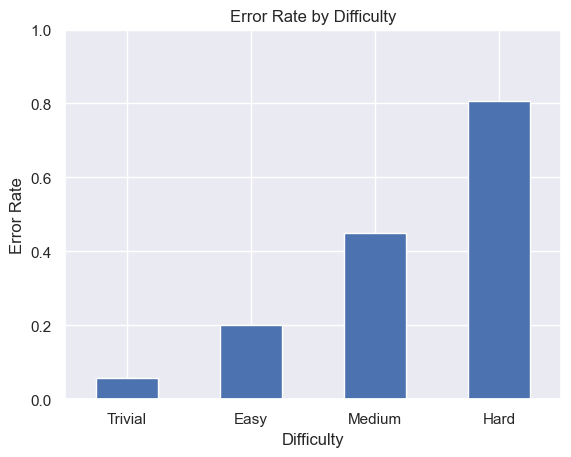

In [23]:
error_by_difficulty = df_data_full_body[['Difficulty', "Difficulty Name", "Error"]].groupby(["Difficulty Name"]).mean().sort_values(by="Difficulty")["Error"]
ax = error_by_difficulty.plot.bar()
ax.set_ylabel("Error Rate")
ax.set_xlabel("Difficulty")
ax.set_title("Error Rate by Difficulty")
ax.set_ylim(0, 1)
labels = ['Trivial', 'Easy', 'Medium', 'Hard']
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(labels, rotation=0, ha='center')
plt.savefig("figures/dist_full_body/Error_Rate_by_Difficulty.png")
ax

#### Body Halves

In [24]:
df_data_half_body["Joint Name"] = df_data_half_body["Joint"].apply(lambda x: body_halves[x])
df_data_half_body["Difficulty Name"] = df_data_half_body["Difficulty"].apply(lambda x: "Trivial" if x == 0 else "Easy" if x == 1 else "Medium" if x == 2 else "Hard")
#df_data_half_body["Error"] = df_data_half_body[["Joint Name", "Error"]].apply(lambda x: x["Joint Name"] if x["Error"] == 1 else "No Error", axis=1)
df_data_half_body

,Type,Session,Difficulty,Exercise,Frame,Joint,Error,mode,Joint Name,Difficulty Name
1,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,1,Mode.HALF_BODY,Upper Half,Trivial
2,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,1,1,Mode.HALF_BODY,Lower Half,Trivial
30,Train,Session 2023-02-28T22:58:23,0,E-0.00,1,0,1,Mode.HALF_BODY,Upper Half,Trivial
31,Train,Session 2023-02-28T22:58:23,0,E-0.00,1,1,1,Mode.HALF_BODY,Lower Half,Trivial
59,Train,Session 2023-02-28T22:58:23,0,E-0.00,2,0,1,Mode.HALF_BODY,Upper Half,Trivial
...,...,...,...,...,...,...,...,...,...,...
22535,Test,Session 2023-03-01T14:55:16,3,E-3.01,27,1,1,Mode.HALF_BODY,Lower Half,Hard
22563,Test,Session 2023-03-01T14:55:16,3,E-3.01,28,0,0,Mode.HALF_BODY,Upper Half,Hard
22564,Test,Session 2023-03-01T14:55:16,3,E-3.01,28,1,1,Mode.HALF_BODY,Lower Half,Hard
22592,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,0,0,Mode.HALF_BODY,Upper Half,Hard


<Axes: title={'center': 'Error Rate by Difficulty'}, xlabel='Difficulty', ylabel='Error Rate'>

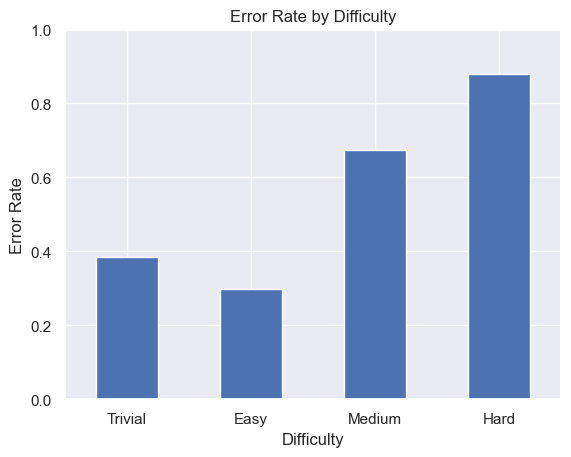

In [25]:
error_by_difficulty = df_data_half_body[['Difficulty', "Difficulty Name", "Error"]].groupby(["Difficulty Name"]).mean().sort_values(by="Difficulty")["Error"]
ax = error_by_difficulty.plot.bar()
ax.set_ylabel("Error Rate")
ax.set_xlabel("Difficulty")
ax.set_title("Error Rate by Difficulty")
ax.set_ylim(0, 1)
labels = ['Trivial', 'Easy', 'Medium', 'Hard']
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(labels, rotation=0, ha='center')
plt.savefig("figures/dist_half_body/Error_Rate_by_Difficulty.png")
ax

C:\Users\leona\AppData\Local\Temp\ipykernel_6524\3385676045.py:18: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axs = edj.plot.pie(ax=ax1, subplots=True, layout=(1, 2), legend=False, title="Error Distribution by Body Half", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.1), autopct='%1.1f%%', pctdistance=1.25)


[]

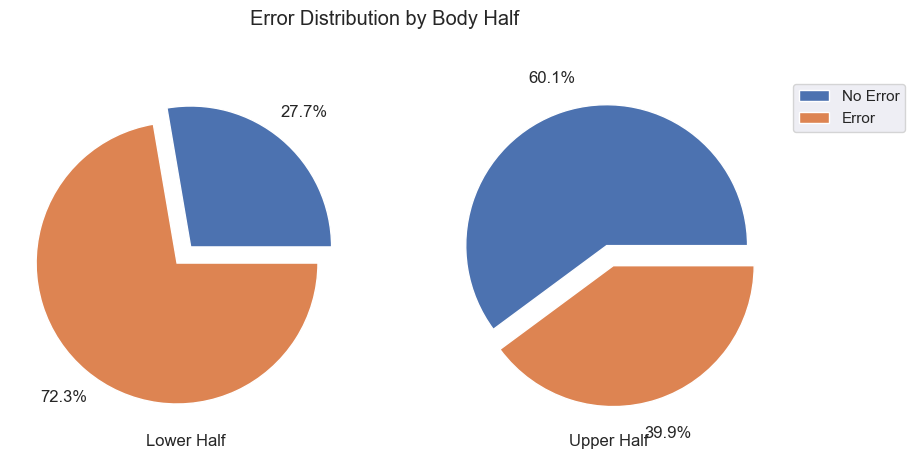

In [26]:
s = df_data_half_body[["Joint", "Error"]].groupby(["Joint"]).sum()
s["Sorted Names"] = body_halves
s = s.sort_values(by="Error", ascending=False)

err_joints = df_data_half_body[["Joint", "Joint Name", "Error"]]
error_distribution_by_joint = err_joints.groupby(["Joint", "Error"]).count().unstack().reindex(s.index).T

error_distribution_by_joint = (error_distribution_by_joint / error_distribution_by_joint.sum()).T.fillna(0)
error_distribution_by_joint.columns = error_distribution_by_joint.columns.droplevel()

error_distribution_by_joint.index = s["Sorted Names"].tolist()

edj = error_distribution_by_joint.T

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)

axs = edj.plot.pie(ax=ax1, subplots=True, layout=(1, 2), legend=False, title="Error Distribution by Body Half", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.1), autopct='%1.1f%%', pctdistance=1.25)

for ax in axs.flatten():
  ax.set_xlabel(ax.get_ylabel())
  ax.set_ylabel("")

plt.legend(["No Error", "Error"], loc='upper left', bbox_to_anchor=(1, 1))

ax1.set_title("Error Distribution by Body Half")
plt.savefig("figures/dist_half_body/Error_Distribution_by_Body_Half.png")
plt.plot()

#### Limbs

In [27]:
df_data_limbs["Joint Name"] = df_data_limbs["Joint"].apply(lambda x: limbs[x])
df_data_limbs["Difficulty Name"] = df_data_limbs["Difficulty"].apply(lambda x: "Trivial" if x == 0 else "Easy" if x == 1 else "Medium" if x == 2 else "Hard")
df_data_limbs

,Type,Session,Difficulty,Exercise,Frame,Joint,Error,mode,Joint Name,Difficulty Name
3,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,0,Mode.LIMBS,Head,Trivial
4,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,1,0,Mode.LIMBS,Torso,Trivial
5,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,2,1,Mode.LIMBS,Left arm,Trivial
6,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,3,0,Mode.LIMBS,Right arm,Trivial
7,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,4,1,Mode.LIMBS,Left leg,Trivial
...,...,...,...,...,...,...,...,...,...,...
22595,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,1,0,Mode.LIMBS,Torso,Hard
22596,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,2,0,Mode.LIMBS,Left arm,Hard
22597,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,3,0,Mode.LIMBS,Right arm,Hard
22598,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,4,1,Mode.LIMBS,Left leg,Hard


<Axes: title={'center': 'Error Rate by Difficulty'}, xlabel='Difficulty', ylabel='Error Rate'>

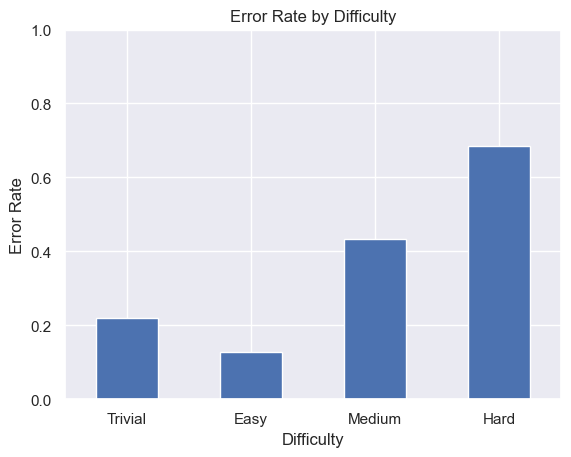

In [28]:
error_by_difficulty = df_data_limbs[['Difficulty', "Difficulty Name", "Error"]].groupby(["Difficulty Name"]).mean().sort_values(by="Difficulty")["Error"]
ax = error_by_difficulty.plot.bar()
ax.set_ylabel("Error Rate")
ax.set_xlabel("Difficulty")
ax.set_title("Error Rate by Difficulty")
ax.set_ylim(0, 1)
labels = ['Trivial', 'Easy', 'Medium', 'Hard']
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(labels, rotation=0, ha='center')
plt.savefig("figures/dist_limbs/Error_Rate_by_Difficulty.png")
ax

C:\Users\leona\AppData\Local\Temp\ipykernel_6524\1131748823.py:18: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axs = edj.plot.pie(ax=ax1, subplots=True, layout=(2, 3), legend=False, title="Error Distribution by Limb", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.1), autopct='%1.1f%%', pctdistance=1.4)


[]

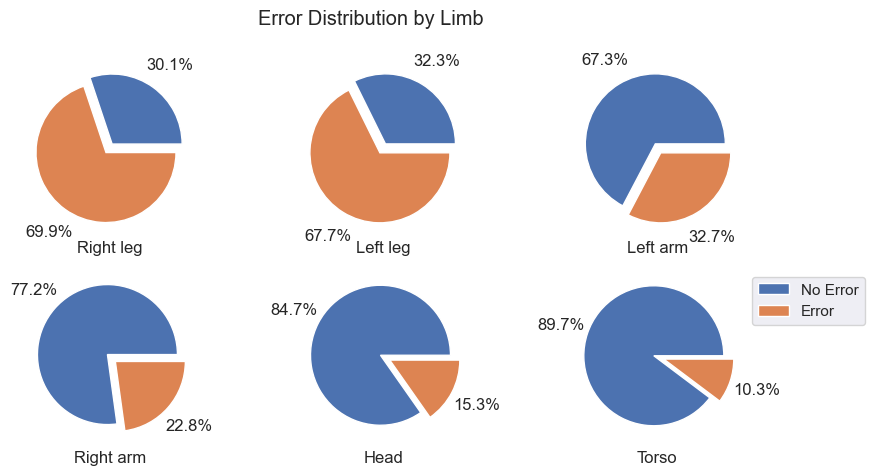

In [29]:
s = df_data_limbs[["Joint", "Error"]].groupby(["Joint"]).sum()
s["Sorted Names"] = limbs
s = s.sort_values(by="Error", ascending=False)

err_joints = df_data_limbs[["Joint", "Joint Name", "Error"]]
error_distribution_by_joint = err_joints.groupby(["Joint", "Error"]).count().unstack().reindex(s.index).T

error_distribution_by_joint = (error_distribution_by_joint / error_distribution_by_joint.sum()).T.fillna(0)
error_distribution_by_joint.columns = error_distribution_by_joint.columns.droplevel()

error_distribution_by_joint.index = s["Sorted Names"].tolist()

edj = error_distribution_by_joint.T

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(2, 3, 1)

axs = edj.plot.pie(ax=ax1, subplots=True, layout=(2, 3), legend=False, title="Error Distribution by Limb", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.1), autopct='%1.1f%%', pctdistance=1.4)

for ax in axs.flatten():
  ax.set_xlabel(ax.get_ylabel())
  ax.set_ylabel("")

plt.legend(["No Error", "Error"], loc='upper left', bbox_to_anchor=(1, 1))

ax1.set_title("Error Distribution by Limb")
plt.savefig("figures/dist_limbs/Error_Distribution_by_Limb.png")
plt.plot()